In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['grid.color'] = 'white'


pathfile=r'/media/nicolascatz/4d767acb-7d35-42a5-b630-86a61f8774d0/nicolascatz/DATA/Projets/CRPN_DTI_AGING_DPAKNC/'

pathdata=pathfile+'data/'
pathdata_tractography=pathfile+'data/Corrected_Tractometry2025'
pathcsv=pathfile+'CSV/'
os.chdir(pathfile)



addtotitle='_112025_42s' # to specify the version of the data

Aging_INDICES = pd.read_csv('Subject_preproc' + addtotitle + '.csv')

CCx_list = ['CC_1','CC_2','CC_3','CC_4','CC_5','CC_6','CC_7']

DTI=np.zeros((42, 98, 7))  # 10 DTI metrics
for i, CC in enumerate(CCx_list):
    file_path = os.path.join(pathcsv, f'{CC}_FA{addtotitle}.csv')
    dfCCx = pd.read_csv(file_path, sep=",")

    DTI[:,:,i]=dfCCx.values  ## une variable DTI of shape subjects x nodes x n CC




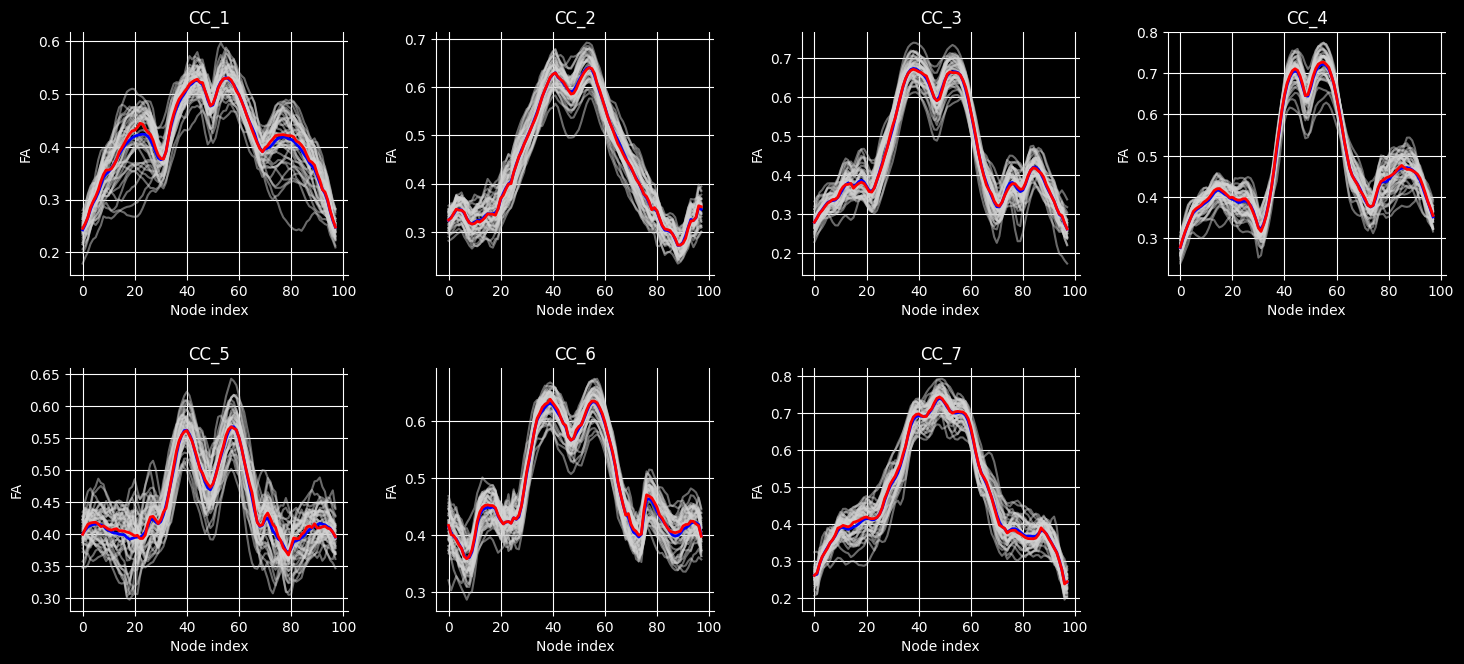

In [19]:
CCx_list = ['CC_1','CC_2','CC_3','CC_4','CC_5','CC_6','CC_7']
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))
axs = axs.flatten()


for i, CCx in enumerate(CCx_list[0:7]):
    file_path = os.path.join(pathcsv, f'{CCx}_FA{addtotitle}.csv')

    axs[i].plot(DTI[:,:,i].T, color='lightgray', alpha=0.5)
    axs[i].plot(DTI[:,:,i].mean(axis=0), color='blue', linewidth=2)
    axs[i].plot(np.median(DTI[:,:,i], axis=0), color='red', linewidth=2)
    axs[i].set_xlabel('Node index')
    axs[i].set_ylabel('FA')
    axs[i].grid(True)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_title(CCx)
    
fig.delaxes(axs[7])
plt.tight_layout(pad=2.0)



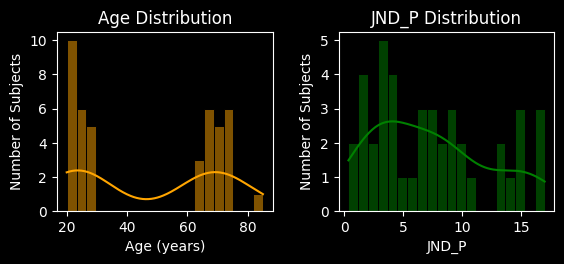

In [20]:
 # target var

import seaborn as sns

age = Aging_INDICES['age'].values
jnd = Aging_INDICES['JND_P'].values


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs = axs.flatten()

sns.histplot(age, bins=20, ax=axs[0],color='orange',kde=True)
axs[0].set_title('Age Distribution')
axs[0].set_xlabel('Age (years)')
axs[0].set_ylabel('Number of Subjects')
sns.histplot(jnd, bins=20, ax=axs[1],color='green',kde=True)
axs[1].set_title('JND_P Distribution')
axs[1].set_xlabel('JND_P')
axs[1].set_ylabel('Number of Subjects')
plt.tight_layout(pad=2.0)
plt.show()



test of Regression models with DTI data on CC6

In [ ]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, SelectFromModel
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, make_scorer
 



X=DTI[:,:,6]  # example with CC_6 (index 5)
y=age  # target variable (age ou jnd)



# Séparation des données en entraînement et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des données 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


param_grid = {'alpha': [0.0001,0.001,0.01,0.1,1,10,100]}  # Valeurs de alpha à tester
lasso_cv = GridSearchCV(Lasso(), param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train_scaled, y_train)

y_pred = lasso_cv.predict(X_test_scaled)

# Évaluation des performances
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R2: {r2}")
print(f"MAE: {mae}")

print(lasso_cv.best_estimator_)
lasso3=Lasso(alpha=1)
lasso3.fit(X_train_scaled, y_train)
lasso3.intercept_
lasso3.coef_
df = pd.DataFrame({
    'Feature_Index': np.arange(X.shape[1]),
    'Coefficient': lasso3.coef_
})

df

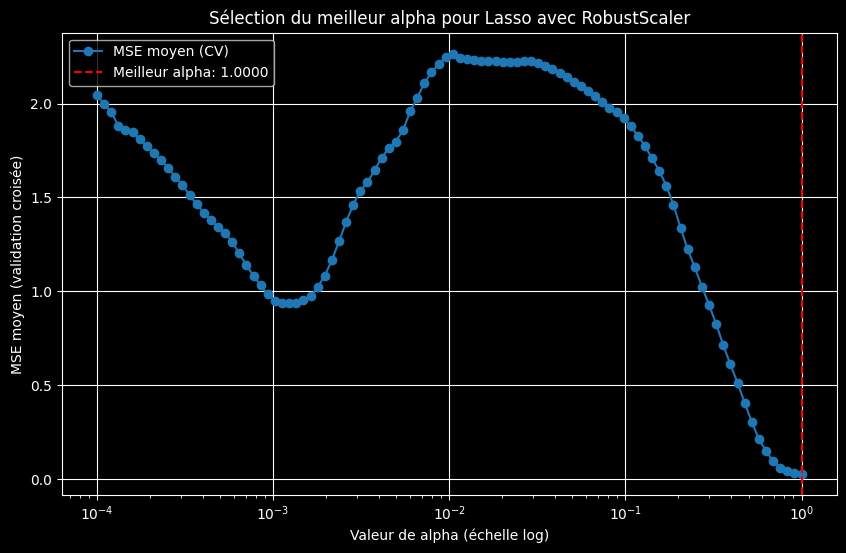

Meilleur alpha: 1.0
MSE sur le test: 392.3877008379267
R² sur le test: 0.2085411681888525
Nombre de variables sélectionnées: 13


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Supposons que X et y soient déjà définis (42 lignes, 98 variables)
# X = vos données (42, 98)
# y = votre variable cible (42,)

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création de la pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('lasso', Lasso(max_iter=10000))
])

# Définition de la grille de paramètres pour alpha
param_grid = {'lasso__alpha': np.logspace(-4, 0, 100)}

# Initialisation de GridSearchCV
grid_lasso = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Ajustement du modèle
grid_lasso.fit(X_train, y_train)

# Récupération des résultats de la validation croisée
results = grid_lasso.cv_results_
alphas = param_grid['lasso__alpha']
mean_scores = -results['mean_test_score']  # Conversion en MSE positif

# Meilleur modèle et prédictions
best_model = grid_lasso.best_estimator_
y_pred = best_model.predict(X_test)

# Métriques
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
num_non_zero = np.sum(best_model.named_steps['lasso'].coef_ != 0)

# Tracé des résultats
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, mean_scores, marker='o', label='MSE moyen (CV)')
plt.axvline(grid_search.best_params_['lasso__alpha'], color='r', linestyle='--',
            label=f'Meilleur alpha: {grid_search.best_params_["lasso__alpha"]:.4f}')
plt.xlabel('Valeur de alpha (échelle log)')
plt.ylabel('MSE moyen (validation croisée)')
plt.title('Sélection du meilleur alpha pour Lasso avec RobustScaler')
plt.legend()
plt.grid(True)
plt.show()

# Affichage des résultats
print("Meilleur alpha:", grid_search.best_params_['lasso__alpha'])
print("MSE sur le test:", mse)
print("R² sur le test:", r2)
print("Nombre de variables sélectionnées:", num_non_zero)
